In [1]:
from collections import defaultdict
import random
import numpy as np
np.set_printoptions(precision=2, suppress=True)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")
sns.set_palette("tab10")
colors = sns.color_palette("bright")

import time
import copy 
import multiprocess as mp

import gym
from env import FrozenLakeCustom, FrozenLakeSimulator

from mcts_haver import run_mcts_trial
from value_iteration import value_iteration

from config import parse_args
from utils import MultiProcess

import logging
logger = logging.getLogger()
logger.setLevel(logging.FATAL)

In [2]:
np.random.seed(0)
random.seed(0)

# params
args = parse_args()

#
env_id = "FrozenLake-v1"
env = FrozenLakeCustom(
    map_name=args["map_name"], is_slippery=args["is_slippery"],
    render_mode=args["render_mode"])

simulator = FrozenLakeSimulator(env.P)

V_vit, Q_vit = value_iteration(
    simulator, args["gamma"], args["vit_thres"])
# global Q_vit_g = Q_vit
        
for state in range(simulator.num_states):
    logging.warning(f"\n-> state = {state}")
    logging.warning(f"V[state] = {V_vit[state]:0.4f}")
    for action in range(simulator.num_actions):
        logging.warning(f"Q[state][action] = {Q_vit[state][action]:0.4f}")
    logging.warning(f"best_action={np.argmax(Q_vit[state])}")
    
manager = mp.Manager()
ep_reward_list = manager.list()
Q_mcts_list = manager.list()

def run_trial(i_trial, Q_vit, args):

    random.seed(10000+i_trial)
    np.random.seed(10000+i_trial)

#     env = FrozenLakeCustom(
#         map_name=args["map_name"], is_slippery=args["is_slippery"],
#         render_mode=args["render_mode"])

#     simulator = FrozenLakeSimulator(env.P)

    Q_mcts, ep_reward = run_mcts_trial(env, simulator, Q_vit, i_trial, args)

    ep_reward_list.append(ep_reward)
    Q_mcts_list.append(Q_mcts)
    return ep_reward

In [3]:
args["update_method"] = "avg"
args["rollout_method"] = ""

print(f"num_trials = {args['num_trials']}")
# print(f"mcts_num_trajectories = {args['mcts_num_trajectories']}")

Q_mcts_dict = defaultdict()


hparam_ucb_scale_list = np.arange(10, 100, 10)
# hparam_ucb_scale_list = np.arange(20, 64, 4)
hparam_ucb_scale_list = [1, 2, 4, 8, 16, 32, 64, 128]
# hparam_ucb_scale_list = [2**i for i in range(1, 9)]

num_trajectories_list = [200, 500, 1000, 1500, 2000, 2500, 3000]
# num_trajectories_list = [200, 500, 800]
# num_trajectories_list = [800]

hparam_ucb_scale_list = [32, 32, 64, 64, 32, 64, 64]


reward_mean_dict = defaultdict(list) 
update_method_list = ["avg", "haver", "max"]
for i_traj, num_trajectories in enumerate(num_trajectories_list):
    args["mcts_num_trajectories"] = num_trajectories
    args["hparam_ucb_scale"] = hparam_ucb_scale_list[i_traj]
    args["hparam_haver_var"] = hparam_ucb_scale_list[i_traj]**2
    
    print(f"\n-> num_trajectories = {num_trajectories}")
    print(f"hparam_ucb_scale = {hparam_ucb_scale_list[i_traj]}")
    print(f"hparam_haver_var = {hparam_ucb_scale_list[i_traj]**2}")
        
    for update_method in update_method_list:
        args["update_method"] = update_method 
        print(f"update_method = {update_method}")
        
        start_time = time.time()
        processes = MultiProcess()
        processes.run(
            run_trial, [(i, Q_vit, args) for i in range(args["num_trials"])])

        reward_mean = np.mean(ep_reward_list)
        reward_std = np.std(ep_reward_list, ddof=1) if len(ep_reward_list) > 1 else 0
        print(f"reward = {reward_mean:0.2f} +/- {reward_std:0.2f}")

        # Q_mcts_dict[f"{hparam_ucb_scale}"] = copy.deepcopy(Q_mcts_list)
        reward_mean_dict[update_method].append(reward_mean)
        
        ep_reward_list[:] = []
        Q_mcts_list[:] = []
    
        end_time = time.time()
        print(f"it takes {end_time-start_time:0.4f}")
        
    
    

num_trials = 20

-> num_trajectories = 200
hparam_ucb_scale = 32
hparam_haver_var = 1024
update_method = avg
reward = -101.00 +/- 0.00
it takes 0.3709
update_method = haver
reward = -101.00 +/- 0.00
it takes 0.5631
update_method = max
reward = -101.00 +/- 0.00
it takes 0.3662

-> num_trajectories = 500
hparam_ucb_scale = 32
hparam_haver_var = 1024
update_method = avg
reward = -101.00 +/- 0.00
it takes 0.6739
update_method = haver
reward = -101.00 +/- 0.00
it takes 1.0996
update_method = max
reward = -101.00 +/- 0.00
it takes 0.6627

-> num_trajectories = 1000
hparam_ucb_scale = 64
hparam_haver_var = 4096
update_method = avg
reward = -4.00 +/- 0.00
it takes 5.1751
update_method = haver
reward = -11.46 +/- 26.90
it takes 7.2755
update_method = max
reward = -101.00 +/- 0.00
it takes 1.2644

-> num_trajectories = 1500
hparam_ucb_scale = 64
hparam_haver_var = 4096
update_method = avg
reward = -4.00 +/- 0.00
it takes 7.7787
update_method = haver
reward = -101.00 +/- 0.00
it takes 3.1686
upda

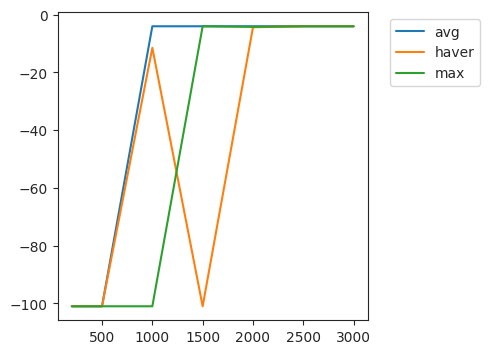

In [4]:
fig, axes = fig, axes = plt.subplots(
        nrows=1, ncols=1, sharex=True, sharey=False, figsize=(4,4))
# axes = [axes]

x_ary = num_trajectories_list

for update_method in update_method_list:
    axes.plot(x_ary, reward_mean_dict[update_method], label=update_method)

optimal_reward = -4
# axes.axhline(y=optimal_reward, color="black")
axes.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()